# Kaggle Titanic survival - Regularisation

A danger with complex models (many features) or small data sets (a low number of samples) is that the model can over-fit to the training data at the expense of previously unseen data (as in the test set). Most machine learning approaches allow for use of some kind of 'regularisation' which reduces the strength of the fit to the training data (e.g. by reducing the values of the model weights/coefficients). While this reduces the accuracy of the fit to the training data it can, perhaps surprisingly, increase the accuracy of predicting test (or other previously unseen) data.

Over-fitting is usually spotted by the accuracy of prediction being significantly higher for the training set compared to the test set.

Here we will deliberately reduce the number of samples in the Titanic data set, and increase the number of features with polynomial expansion*, to exaggerate the problem of over-fitting, and show how regularisation can help.

Note: This workbook follows on from previous workbooks on logistic regression and stratified k-fold validation, both of which are used here,

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/02_logistic_regression.ipynb

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/03_k_fold.ipynb

*When we use polynomial expansion of features, we create new features that are the product of two features. For example if we had two features, A and B, we would produce the following extra features:
* A*A
* A*B
* B*A
* B*B


## Load modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Download data

Run the following code if data for Titanic survival has not been previously downloaded.

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv')

## Load data

In [3]:
data = pd.read_csv('data/processed_data.csv')

In [4]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
data.drop('PassengerId', inplace=True, axis=1)

## Divide into X (features) and y (lables)

In [5]:
# Split data into two DataFrames
X_df = data.drop('Survived',axis=1)
y_df = data['Survived']

# Convert DataFrames to NumPy arrays
X = X_df.values
y = y_df.values

## Reduce the number of samples, and increase the number of features

Now we will reduce the size of the data set using random sampling (using Pandas `sample` method). 
We will increase the number fo features using polynomial expansion (creating products of each pair of features).

This is to help show the effect of over-fitting, as small data sets are more susceptible to over-fitting.

In [6]:
# Reduce number of samples
data = data.sample(150)

In [7]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)

## Define function to standardise data
Standardisation subtracts the mean and divides by the standard deviation, for each feature.
Here we use the sklean built-in method for standardisation.

In [8]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Training and testing the model for all k-fold splits

The following code:
* Defines a list of regularisation (lower values lead to greater regularisation)
* Sets up lists to hold results for each k-fold split
* Starts a loop for each regularisation value, and loops through:
    * Print regularisation level (to show progress)
    * Sets up lists to record replicates from k-fold stratification
    * Sets up the k-fold splits using sklearns `StratifiedKFold` method
    * Trains a logistic regression model, and test its it, for eack k-fold split
    * Adds each k-fold training/test accuracy to the lists
* Record average accuracy from k-fold stratification (so each regularisation level has one accuracy result recorded for training and test sets)

We pass the regularisation to the model during fitting, it has the argument name `C`.

In [9]:
reg_values = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

# Set up lists to hold results
training_acc_results = []
test_acc_results = []

# Set up splits
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

# Set up model type

for reg in reg_values:
    # Show progress
    print(reg, end=' ')
    
    # Set up lists for results for each of k splits
    training_k_results = []
    test_k_results = []
    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X, y):
        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Standardise X data
        X_train_std, X_test_std = standardise_data(X_train, X_test)
        # Fit model with regularisation (C)
        model = LogisticRegression(C=reg, solver='lbfgs', max_iter=1000)
        model.fit(X_train_std,y_train)
        # Predict training and test set labels
        y_pred_train = model.predict(X_train_std)
        y_pred_test = model.predict(X_test_std)
        # Calculate accuracy of training and test sets
        accuracy_train = np.mean(y_pred_train == y_train)
        accuracy_test = np.mean(y_pred_test == y_test)
        # Record accuracy for each k-fold split
        training_k_results.append(accuracy_train)
        test_k_results.append(accuracy_test)
    # Record average accuracy for each k-fold split
    training_acc_results.append(np.mean(training_k_results))
    test_acc_results.append(np.mean(test_k_results))

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

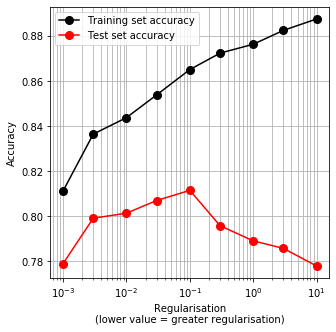

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define data for chart
x = reg_values
y1 = training_acc_results
y2 = test_acc_results

# Set up figure
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

# Plot training set accuracy
ax1.plot(x, y1,
        color = 'k',
        linestyle = '-',
        markersize = 8,
        marker = 'o',
        markerfacecolor='k',
        markeredgecolor='k',
        label  = 'Training set accuracy')

# Plot test set accuracy
ax1.plot(x, y2,
        color = 'r',
        linestyle = '-',
        markersize = 8,
        marker = 'o',
        markerfacecolor='r',
        markeredgecolor='r',
        label  = 'Test set accuracy')

# Custimise axes
ax1.grid(True, which='both')
ax1.set_xlabel('Regularisation\n(lower value = greater regularisation)')
ax1.set_ylabel('Accuracy')
ax1.set_xscale('log')

# Add legend
ax1.legend()

# Show plot
plt.show()

Note in the above figure that:

1) Accuracy of training set is significantly higher than accuracy of test set (a common sign of over-fitting).

2) There is an optimal value for the regularisation constant, C. In this case that value is about 0.1 (default if not specified is 1.0).